<a href="https://colab.research.google.com/github/RosaliaGimenezBDS/M9_Reto_01/blob/main/Copia_de_Reto_1_M09_Notebook_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Máster en Behavioral Data Science**
## **Instituto de Formación Continua (IL3) - Universitat de Barcelona**
## **Módulo 9: Aprendizaje Profundo - Reto 1** - (Notebook 5/5)
Autores: **Meysam Madadi** & **Julio C. S. Jacques Junior**

---

# **Prerrequisitos**
- Consultar las instrucciones en los *Jupyter notebooks* anteriores.
- Ejecutar los *Jupyter notebooks* anteriores, en este caso:
 - *Jupyter notebook* 1.
 - *Jupyter notebook* 2.
 - *Jupyter notebook* 3.
 - *Jupyter notebook* 4.

# **Los objetivos de este Jupyter notebook**
- **Evaluar una estrategia diferente para la mitigación de sesgos que no dependa del aumento de datos**, basada en una **función de pérdida ponderada**.
- Refinaremos el modelo obtenido al final de la Etapa 1 usando una segunda etapa, pero ahora con esta nueva función de pérdida ponderada.
- Luego, evaluaremos los de sesgos y compararemos los resultados.
---

## Comprobando la versión de tensorflow

In [9]:
# Este código fue probado en tensorflow 2.15.0
#import tensorflow as tf
import tensorflow as tf
import tf_keras
print(tf.__version__)

print("GPU disponible:", tf.config.list_physical_devices('GPU'))



2.17.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Montando nuestro Google Drive para guardar/cargar nuestros resultados

In [7]:
#--------------------------
MOUNT_GOOGLE_DRIVE = True
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/M09-P01/' as I
  # created a '/M09-P01/' folder in my google drive for this purpose.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Cargando el modelo y los datos preprocesados desde Drive

In [2]:
import numpy as np
import tensorflow as tf
#import random
#import gc

with open('/content/gdrive/MyDrive/M09-P01/train.npy', 'rb') as f:
  X_train = np.load(f)
  Y_train = np.load(f)
  M_train = np.load(f)
with open('/content/gdrive/MyDrive/M09-P01/valid.npy', 'rb') as f:
  X_valid = np.load(f)
  Y_valid = np.load(f)
  M_valid = np.load(f)
with open('/content/gdrive/MyDrive/M09-P01/test.npy', 'rb') as f:
  X_test = np.load(f)
  Y_test = np.load(f)
  M_test = np.load(f)

# the model is loaded in the next cell

# **Mitigando el problema de sesgo utilizando una función de pérdida ponderada** (*weighted loss*).
- A continuación, crearemos una **"función de pérdida personalizada", que da más peso a las personas que tienen menos muestras en los datos de entrenamiento**. De esta forma, la red intentará predecir mejor sus edades al intentar minimizar la pérdida total, "minimizando" el problema de desbalance de datos.
- Para este ejemplo, **consideraremos solo el atributo de edad**, pero se podrían considerar otras categorías, así como soluciones más sofisticadas.


# **Generando los pesos para las muestras de entrenamiento**
- Primero, generaremos un peso para cada grupo de edad (para g=1 a 4, es decir, "0-19", "20-39", "40-59" y "60-100");
- La fórmula utilizada para calcular el peso de cada grupo $j$ es:

  $w_j=n_{samples} / (n_{classes} * n_{samples,j}),$

  Dónde

     - $w_j$ es el peso de cada grupo $j$,
     - $n_{samples}$ es el número de muestras en el conjunto de entrenamiento,
     - $n_{clases}$ es el número de clases (4 en nuestro caso, ya que hemos dividido las edades en 4 grupos),
     - $n_{samples,j}$ es el número de muestras de la clase $j$.
- Durante el entrenamiento, le pasamos a *kereas* un vector de pesos, y la función de pérdida se calculará teniendo en cuenta el peso de cada grupo y la respectiva etiqueta de la muestra de entrenamiento.

In [3]:
# counting the number of samples per group in the train data (age attribute only)
g1 = g2 = g3 = g4 = 0
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      g1 +=1
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      g2 +=1
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      g3 +=1
    if(Y_train[i]*100>=60):
      g4 +=1
print('group(s) size = ', [g1, g2, g3, g4])

# generating the weights for each group using the equation defined above
w = sum(np.array([g1, g2, g3, g4]))/(4*np.array([g1, g2, g3, g4]))
print('weights per group = ', w)

# creating a vector with same size as Y_train, that will link a particular label to its weight
sample_weights = []
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      sample_weights.append(w[0])
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      sample_weights.append(w[1])
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      sample_weights.append(w[2])
    if(Y_train[i]*100>=60):
      sample_weights.append(w[3])
sample_weights = np.array(sample_weights)

group(s) size =  [623, 1730, 527, 120]
weights per group =  [1.20385233 0.43352601 1.42314991 6.25      ]


# **Refinando nuestro modelo con una función de pérdida ponderada**
- Ahora, en lugar de simplemente ajustar el modelo aprendido en la etapa 1 con la segunda etapa, **ajustamos el modelo aprendido en la etapa 1 con la segunda etapa, nuestra función de pérdida ponderada (y sin aumento de datos)**. De esta manera, podemos comparar las diferentes estrategias.

In [10]:
import pickle

# LOADING THE PREVIOUSLY TRAINED MODEL
model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/best_model_st1.h5')

# setting all layers of the model to trainable
model.trainable = True

#### MODEL TRAINING ####
# defining the early stop criteria
es = tf_keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# saving the best model based on val_loss
mc = tf_keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/M09-P01/best_model_st2_custom_loss.h5', monitor='val_loss', mode='min', save_best_only=True)

# defining the optimizer
model.compile(tf_keras.optimizers.Adam(learning_rate=1e-5),loss=tf_keras.losses.MeanSquaredError(),metrics=['mae'])

# training the model
history = model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

# saving training history (for future visualization)
with open('/content/gdrive/MyDrive/M09-P01/train_history_st2_custom_loss.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1/50
94/94 [==============================] - ETA: 0s - loss: 0.2525 - mae: 0.2145

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 77s 504ms/step - loss: 0.2525 - mae: 0.2145 - val_loss: 0.2125 - val_mae: 0.1523
Epoch 2/50
94/94 [==============================] - 37s 391ms/step - loss: 0.2461 - mae: 0.2056 - val_loss: 0.2088 - val_mae: 0.1437
Epoch 3/50
94/94 [==============================] - 40s 431ms/step - loss: 0.2386 - mae: 0.1999 - val_loss: 0.2060 - val_mae: 0.1341
Epoch 4/50
94/94 [==============================] - 42s 453ms/step - loss: 0.2283 - mae: 0.1868 - val_loss: 0.2028 - val_mae: 0.1282
Epoch 5/50
94/94 [==============================] - 47s 506ms/step - loss: 0.2201 - mae: 0.1756 - val_loss: 0.2027 - val_mae: 0.1293
Epoch 6/50
94/94 [==============================] - 46s 491ms/step - loss: 0.2134 - mae: 0.1662 - val_loss: 0.1987 - val_mae: 0.1170
Epoch 7/50
94/94 [==============================] - 50s 531ms/step - loss: 0.2083 - mae: 0.1553 - val_loss: 0.1955 - val_mae: 0.1067
Epoch 8/50
94/94 [==============================] - 47s 504ms/step - loss: 0.204

## Evaluando el modelo entrenado (Etapa 2, con una función de pérdida ponderada) en el conjunto de prueba

In [11]:
#loading the best model
model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/best_model_st2_custom_loss.h5')

# Evaluate the trained model on the test set
print('Evaluating on the test set')
predictions_st2_custom_loss = model.predict(X_test, batch_size=32, verbose=1)

# Computing the Mean Absolute Error
# Also re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
mae = np.mean(abs(predictions_st2_custom_loss[:,0] - Y_test)*100)

# Next we print the average error. Note that the error is rescaled back to the range [0-100]
print('\nThe final mean absolute error (on the Test set)  is ' + str(mae) + ' years old.')

Evaluating on the test set
32/32 [==============================] - 3s 75ms/step

The final mean absolute error (on the Test set)  is 4.4119289342733445 years old.


# **Comparando ambos modelos en términos de valores de sesgo**
- A continuación, evaluamos los valores de sesgo obtenidos por cada modelo:
 - Etapa 2 (estándar);
 - Etapa 2, con una función de pérdida ponderada.

In [12]:
# downloading our "bias library", which contains the functions used to evaluate
# the different bias scores
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r1/bias_functions.py

--2024-09-12 20:27:37--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r1/bias_functions.py
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4355 (4.3K) [application/octet-stream]
Saving to: ‘bias_functions.py’

bias_functions.py   100%[===================>]   4.25K  --.-KB/s    in 0s      

2024-09-12 20:27:38 (529 MB/s) - ‘bias_functions.py’ saved [4355/4355]



In [13]:
# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

# loading the last saved model and perform prediction
model = tf_keras.models.load_model('/content/gdrive/MyDrive/M09-P01/best_model_st2.h5')
predictions_st2 = model.predict(tf.convert_to_tensor(X_test, dtype=tf.float32), batch_size=32, verbose=0)

age_bias(predictions_st2*100, Y_test*100)
age_bias(predictions_st2_custom_loss*100, Y_test*100)

gender_bias(predictions_st2*100, Y_test*100, M_test)
gender_bias(predictions_st2_custom_loss*100, Y_test*100, M_test)

ethnicity_bias(predictions_st2*100, Y_test*100, M_test)
ethnicity_bias(predictions_st2_custom_loss*100, Y_test*100, M_test)

face_expression_bias(predictions_st2*100, Y_test*100, M_test)
face_expression_bias(predictions_st2_custom_loss*100, Y_test*100, M_test)

Age analysis:
Size group 1 = 196, MAE = 3.903450
Size group 2 = 533, MAE = 3.880654
Size group 3 = 171, MAE = 4.087122
Size group 4 = 100, MAE = 7.068462
---------
Age bias (Ba) =  1.6245158513387044
Age analysis:
Size group 1 = 196, MAE = 4.742442
Size group 2 = 533, MAE = 4.103395
Size group 3 = 171, MAE = 4.405019
Size group 4 = 100, MAE = 5.420425
---------
Age bias (Ba) =  0.7147523562113444
Gender analysis:
Size group female = 549, MAE = 4.196381
Size group male = 451, MAE = 4.291344
---------
Gender bias (Bg) =  0.094963074
Gender analysis:
Size group female = 549, MAE = 4.376998
Size group male = 451, MAE = 4.454450
---------
Gender bias (Bg) =  0.07745123
Ethnicity Analysis:
Size group asian = 55, MAE = 4.734657
Size group afroamerican = 21, MAE = 4.541964
Size group caucasian = 924, MAE = 4.202837
---------
Ethnicity bias (Be) =  0.35454686482747394
Ethnicity Analysis:
Size group asian = 55, MAE = 5.541320
Size group afroamerican = 21, MAE = 5.168798
Size group caucasian = 92

# Visualizando el historial de entrenamiento usando diferentes estrategias
- De manera similar a lo observado en el *Jupyter notebook* 4, las curvas de entrenamiento de ambos modelos muestran un comportamiento similar. Sin embargo, creemos que la nueva función de pérdida podría haber contribuido a mitigar el problema de sesgo, y esto puede analizarse de manera cuantitativa.
- En general, los resultados pueden variar un poco según diferentes ejecuciones, debido a factores de inicialización, pero **pueden darnos una idea de lo que se puede hacer para mejorar las capacidades de generalización (y equidad) de nuestro modelo**.

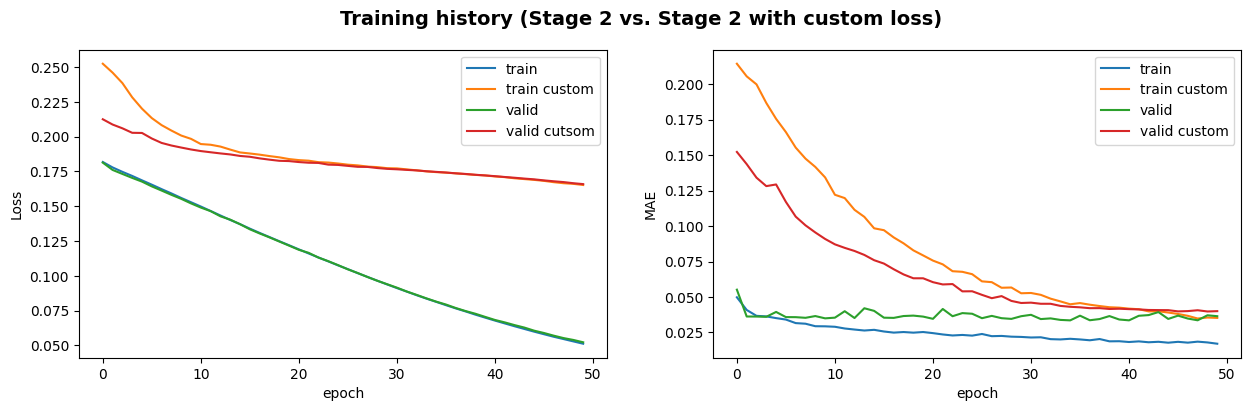

In [14]:
import pickle
from matplotlib import pyplot as plt

train_hist2 = pickle.load(open('/content/gdrive/MyDrive/M09-P01/train_history_st2.pkl',"rb"))
train_hist3 = pickle.load(open('/content/gdrive/MyDrive/M09-P01/train_history_st2_custom_loss.pkl',"rb"))
train_hist4 = pickle.load(open('/content/gdrive/MyDrive/M09-P01/train_history_st2_aug.pkl',"rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (Stage 2 vs. Stage 2 with custom loss)', fontsize=14, fontweight='bold')

ax1.plot(train_hist2['loss'])
ax1.plot(train_hist3['loss'])
ax1.plot(train_hist2['val_loss'])
ax1.plot(train_hist3['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'train custom', 'valid', 'valid cutsom'], loc='upper right')

ax2.plot(train_hist2['mae'])
ax2.plot(train_hist3['mae'])
ax2.plot(train_hist2['val_mae'])
ax2.plot(train_hist3['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'train custom', 'valid', 'valid custom'], loc='upper right')